In [2]:
# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
import scanpy as sc
import scvelo as scv

# data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
label = data.obs['clusters'].tolist()
# Log normalize
sc.pp.log1p(data)

In [14]:
data.shape

(3696, 27998)

In [4]:
from collections import Counter

# assume lst is the list
print(Counter(label))

Counter({'Ductal': 916, 'Ngn3 high EP': 642, 'Pre-endocrine': 592, 'Beta': 591, 'Alpha': 481, 'Ngn3 low EP': 262, 'Epsilon': 142, 'Delta': 70})


In [5]:
types = np.unique(label).tolist()
types = sorted(types)
types

['Alpha',
 'Beta',
 'Delta',
 'Ductal',
 'Epsilon',
 'Ngn3 high EP',
 'Ngn3 low EP',
 'Pre-endocrine']

In [6]:
data.obs['clusters'] = data.obs['clusters'].cat.reorder_categories(types)

In [7]:
# create color palette for 8 cell types
import seaborn as sns

palette = sns.color_palette('husl', n_colors=8)
# palette = ['#D3D3D3'] + palette

In [8]:
# PCA
sc.tl.pca(data, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data, n_neighbors=15)

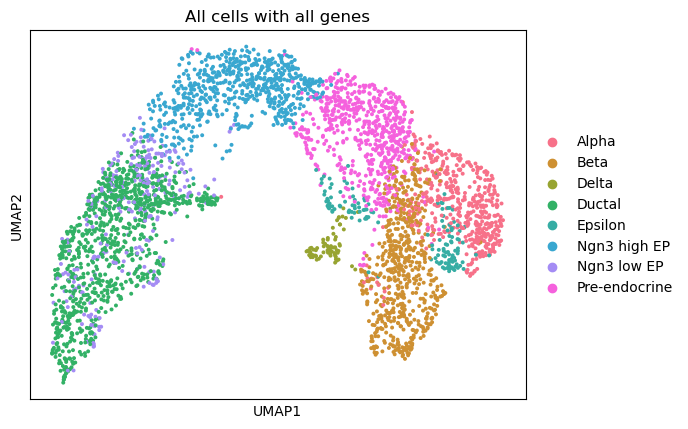

In [9]:
# UMAP
sc.tl.umap(data)
sc.pl.umap(data, color='clusters', title='All cells with all genes', palette=palette)

In [10]:
umap_coordinate = data.obsm['X_umap']
umap_coordinate

array([[12.861348 ,  5.6442475],
       [-1.8272582,  4.15675  ],
       [14.957046 ,  5.6534986],
       ...,
       [ 0.7754398,  3.9322093],
       [16.572588 ,  1.1385686],
       [14.486823 ,  2.1891696]], dtype=float32)

In [11]:
umap_adja_matrix = data.obsp['connectivities']
umap_adja_matrix

<3696x3696 sparse matrix of type '<class 'numpy.float32'>'
	with 75918 stored elements in Compressed Sparse Row format>

In [13]:
umap_adja_matrix_dense = umap_adja_matrix.toarray()
umap_adja_matrix_dense[:100, :100]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
# Export adjacency sparse matrix
# import scipy.sparse as sp

# sp.save_npz('Pancrease_UMAP_adjacency.npz', umap_adja_matrix)

## Compute clustering coefficient

In [16]:
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

Graph with 3696 nodes and 37959 edges


In [17]:
clustering_coeff = nx.clustering(G)

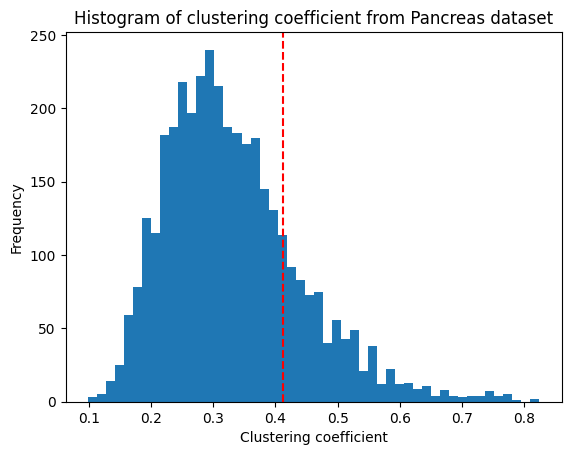

In [18]:
# plot clustering coefficient histogram
coeff = list(clustering_coeff.values())

plt.hist(coeff, bins=50)
plt.axvline(x=np.percentile(coeff, 80), color='r', linestyle='--')
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of clustering coefficient from Pancreas dataset')
plt.show()

## Select nodes with top 20% clustering coefficient

In [37]:
top20_count = int(len(clustering_coeff) * 0.2)
top20_indices = sorted(clustering_coeff, key=clustering_coeff.get, reverse=True)[:top20_count]

In [42]:
selected = {node: clustering_coeff[node] for node in top20_indices}
selected

{2208: 0.8241758241758241,
 3551: 0.8131868131868132,
 2400: 0.7916666666666666,
 2151: 0.7802197802197802,
 2598: 0.7802197802197802,
 2684: 0.7802197802197802,
 675: 0.7692307692307693,
 1839: 0.7692307692307693,
 1103: 0.7619047619047619,
 2869: 0.7583333333333333,
 2236: 0.7582417582417582,
 2799: 0.7582417582417582,
 3072: 0.75,
 858: 0.7472527472527473,
 1523: 0.7472527472527473,
 2875: 0.7472527472527473,
 720: 0.7428571428571429,
 1838: 0.7428571428571429,
 1039: 0.7426470588235294,
 851: 0.7362637362637363,
 380: 0.7333333333333333,
 981: 0.7333333333333333,
 1125: 0.7238095238095238,
 2927: 0.7166666666666667,
 1459: 0.7142857142857143,
 1957: 0.7142857142857143,
 2186: 0.7083333333333334,
 3487: 0.7047619047619048,
 18: 0.6952380952380952,
 1144: 0.6952380952380952,
 2334: 0.6923076923076923,
 2661: 0.6833333333333333,
 178: 0.6813186813186813,
 461: 0.6813186813186813,
 934: 0.6783625730994152,
 2918: 0.6783625730994152,
 2137: 0.6714285714285714,
 44: 0.6703296703296703,
 

In [43]:
len(selected)

739

In [57]:
is_representative = ['Yes' if cell in selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

In [61]:
# Add is_representative (Yes or No) to data.obs
data.obs['is_representative'] = is_representative
data.obs

,clusters_coarse,clusters,S_score,G2M_score,is_representative
index,,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071,No
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610,No
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834,No
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243,No
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030,No
...,...,...,...,...,...
TTTGTCAAGTGACATA,Pre-endocrine,Pre-endocrine,-0.235896,-0.266101,No
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047,No
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907,No


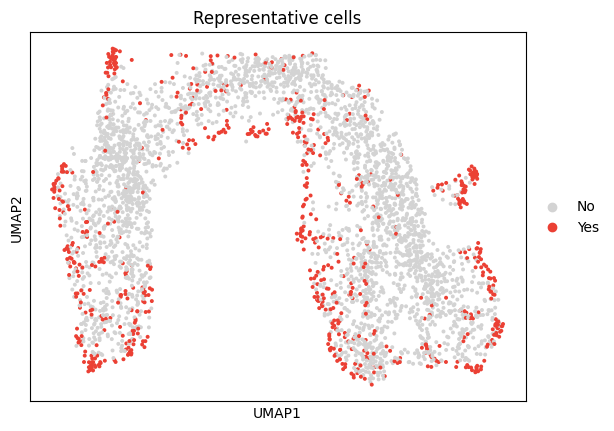

In [68]:
# plot UMAP denoting representative cells
sc.pl.umap(data, color='is_representative', title='Representative cells', palette=['#D3D3D3', '#eb4034'])

## Select top 20% clustering coefficient cells in each cell type

In [19]:
alltype_selected = dict()

for celltype in np.unique(label):
    # select cells from one celltype
    celltype_idx = np.where(data.obs['clusters'] == celltype)[0]
    celltype_coeff = {node: clustering_coeff[node] for node in celltype_idx}
    
    top20_count = int(len(celltype_coeff) * 0.2)
    top20_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top20_count]
    celltype_selected = {node: celltype_coeff[node] for node in top20_indices}
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))

    # celltype_is_representative = ['Yes' if cell in celltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
    # celltype_is_representative = np.array(celltype_is_representative)
    # data.obs['is_representative_' + celltype] = celltype_is_representative

Alpha 96
Beta 118
Delta 14
Ductal 183
Epsilon 28
Ngn3 high EP 128
Ngn3 low EP 52
Pre-endocrine 118


In [27]:
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
data.obs['is_representative'] = is_representative
data.obs

,clusters_coarse,clusters,S_score,G2M_score,is_representative
index,,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071,No
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610,No
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834,No
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243,No
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030,No
...,...,...,...,...,...
TTTGTCAAGTGACATA,Pre-endocrine,Pre-endocrine,-0.235896,-0.266101,Yes
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047,No
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907,No


In [36]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(data.shape[0]):
    if data.obs['is_representative'][i] == 'Yes':
        clus_rep.append(data.obs['is_representative'][i] + '_' + data.obs['clusters'][i])
    else:
        clus_rep.append(data.obs['is_representative'][i])

data.obs['cluster_representative'] = clus_rep

In [37]:
data.obs

,clusters_coarse,clusters,S_score,G2M_score,is_representative,cluster_representative
index,,,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071,No,No
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610,No,No
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834,No,No
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243,No,No
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030,No,No
...,...,...,...,...,...,...
TTTGTCAAGTGACATA,Pre-endocrine,Pre-endocrine,-0.235896,-0.266101,Yes,Yes_Pre-endocrine
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047,No,No
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907,No,No


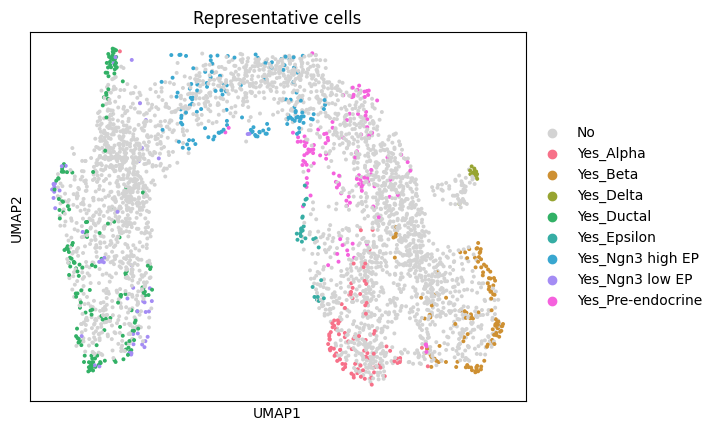

In [60]:
sc.pl.umap(data, color='cluster_representative', title='Representative cells', palette= ['#D3D3D3'] + palette)

In [64]:
!pwd

/home/evanlee/Pancreas_AD2


In [65]:
# export representative cells table
rep_df = data.obs[data.obs['is_representative'] == 'Yes']
rep_df.to_csv('./Pancreas_result/Pancreas_representative_cells.csv')